In [1]:
!python -V

Python 3.9.19


In [2]:
import pandas as pd

In [3]:
import pickle

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge

from sklearn.metrics import mean_squared_error

In [6]:
import mlflow

mlflow.set_tracking_uri("sqlite:///mlflow.db")
mlflow.set_experiment("my-experiment")

<Experiment: artifact_location='/workspaces/mlops/02-Experiment_Tracking/mlruns/1', creation_time=1716555313243, experiment_id='1', last_update_time=1716555313243, lifecycle_stage='active', name='my-experiment', tags={'mlflow.sharedViewState.399ac639b9706e2217d074fa8e075ecb3e5c4b8f006adf40a809918a20b73f4b': '{"searchFilter":"","orderByKey":"attributes.start_time","orderByAsc":false,"startTime":"ALL","lifecycleFilter":"Active","datasetsFilter":[],"modelVersionFilter":"All '
                                                                                            'Runs","selectedColumns":["metrics.`rmse`","params.`alpha`","params.`train-data-link`","params.`val-data-link`","tags.`developer`"],"runsExpanded":{},"runsPinned":[],"runsHidden":[],"runsHiddenMode":"FIRST_10_RUNS","compareRunCharts":[{"uuid":"1716571159702csbzl512","type":"BAR","runsCountToCompare":10,"metricSectionId":"1716571159702iydtxt7k","deleted":false,"isGenerated":true,"metricKey":"rmse"}],"compareRunSections":[{"uuid

In [7]:
df = pd.read_parquet('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')

df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

df = df[(df.duration >= 1) & (df.duration <= 60)]

categorical = ['PULocationID', 'DOLocationID']
numerical = ['trip_distance']

df[categorical] = df[categorical].astype(str)

In [8]:
train_dicts = df[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer()
X_train = dv.fit_transform(train_dicts)

target = 'duration'
y_train = df[target].values

lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_train)

mean_squared_error(y_train, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


9.838799799829628

/tmp/ipykernel_2911/1672306066.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_pred, label='prediction')
/tmp/ipykernel_2911/1672306066.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y_train, label='actual')


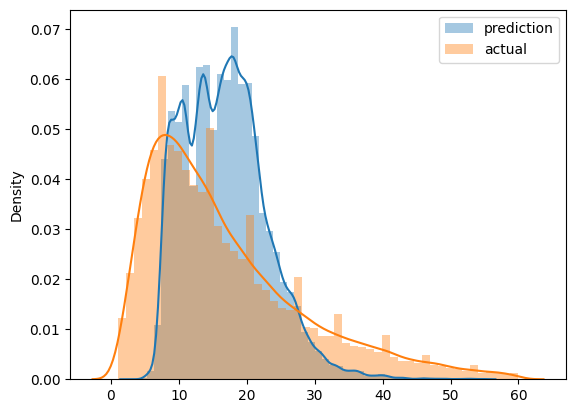

In [9]:
sns.distplot(y_pred, label='prediction')
sns.distplot(y_train, label='actual')

plt.legend()

In [10]:
def read_dataframe(filename):
    if filename.endswith('.csv'):
        df = pd.read_csv(filename)

        df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)
        df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    elif filename.endswith('.parquet'):
        df = pd.read_parquet(filename)

    df['duration'] = df.lpep_dropoff_datetime - df.lpep_pickup_datetime
    df.duration = df.duration.apply(lambda td: td.total_seconds() / 60)

    df = df[(df.duration >= 1) & (df.duration <= 60)]

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    
    return df

In [11]:
df_train = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet')
df_val = read_dataframe('https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet')

In [12]:
len(df_train), len(df_val)

(73908, 61921)

In [13]:
df_train['PU_DO'] = df_train['PULocationID'] + '_' + df_train['DOLocationID']
df_val['PU_DO'] = df_val['PULocationID'] + '_' + df_val['DOLocationID']

In [14]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

In [15]:
target = 'duration'
y_train = df_train[target].values
y_val = df_val[target].values

In [16]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

mean_squared_error(y_val, y_pred, squared=False)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


7.758715200888857

In [17]:
with open('models/lin_reg.bin', 'wb') as f_out:
    pickle.dump((dv, lr), f_out)

In [24]:
with mlflow.start_run():

    mlflow.set_tag("developer", "cristian")

    mlflow.log_param("train-data-link", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-01.parquet")
    mlflow.log_param("val-data-link", "https://d37ci6vzurychx.cloudfront.net/trip-data/green_tripdata_2021-02.parquet")

    alpha = 0.1
    mlflow.log_param("alpha", alpha)

    lr = Lasso(alpha)


    lr.fit(X_train, y_train)

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)


# Logging model as an artifact
    mlflow.log_artifact(local_path="models/lin_reg.bin", artifact_path="models_pickle")


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [26]:
import xgboost as xgb

In [27]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll import scope

In [28]:
train = xgb.DMatrix(X_train, label=y_train)
valid = xgb.DMatrix(X_val, label=y_val)

In [29]:
def objective(params):
    with mlflow.start_run():
        mlflow.set_tag("model", "xgboost")
        mlflow.log_params(params)
        booster = xgb.train(
            params=params,
            dtrain=train,
            num_boost_round=1000,
            evals=[(valid, 'validation')],
            early_stopping_rounds=50
        )
        y_pred = booster.predict(valid)
        rmse = mean_squared_error(y_val, y_pred, squared=False)
        mlflow.log_metric("rmse", rmse)

    return {'loss': rmse, 'status': STATUS_OK}

search_space = {
    'max_depth': scope.int(hp.quniform('max_depth', 3, 100, 1)),
    'learning_rate': hp.loguniform('learning_rate', -4, 0),
    'reg_alpha': hp.loguniform('reg_alpha', -6, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -7, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -2, 3),
    'objective': 'reg:linear',
    'seed': 41
}

best_result = fmin(
    fn=objective,
    space=search_space,
    algo=tpe.suggest,
    max_evals=49,
    trials=Trials()
)

In [33]:
mlflow.xgboost.autolog(disable = True)

In [34]:
# Training using best parameters, also logging using altolog from mlflow
with mlflow.start_run():    
    best_params = {
    'learning_rate': 0.12296859804471552,
    'max_depth': 51,
    'min_child_weight': 1.0269817670264731,
    'objective': 'reg:linear',
    'reg_alpha': 0.0696311171319498,
    'reg_lambda': 0.2817336105256094,
    'seed': 42}

    mlflow.log_params(best_params)

    booster = xgb.train(
        params=best_params,
        dtrain=train,
        num_boost_round=1000,
        evals=[(valid, 'validation')],
        early_stopping_rounds=50
    )

    y_pred = lr.predict(X_val)
    rmse = mean_squared_error(y_val, y_pred, squared=False)
    mlflow.log_metric("rmse", rmse)

    with open("models/preprocessor.b", "wb") as f_out:
        pickle.dump(dv, f_out)
    mlflow.log_artifact("models/preprocessor.b", artifact_path = "preprocessor")

    mlflow.xgboost.log_model(booster, artifact_path = "models_mlflow")


/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:52:22] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[0]	validation-rmse:11.21961
[1]	validation-rmse:10.38558
[2]	validation-rmse:9.68857
[3]	validation-rmse:9.11078
[4]	validation-rmse:8.63138
[5]	validation-rmse:8.23918
[6]	validation-rmse:7.91989
[7]	validation-rmse:7.65661
[8]	validation-rmse:7.44366
[9]	validation-rmse:7.27205
[10]	validation-rmse:7.13235
[11]	validation-rmse:7.01929
[12]	validation-rmse:6.92608
[13]	validation-rmse:6.84919
[14]	validation-rmse:6.78777
[15]	validation-rmse:6.73695
[16]	validation-rmse:6.69510
[17]	validation-rmse:6.66019
[18]	validation-rmse:6.63040
[19]	validation-rmse:6.60506
[20]	validation-rmse:6.58398
[21]	validation-rmse:6.56593
[22]	validation-rmse:6.54990
[23]	validation-rmse:6.53584
[24]	validation-rmse:6.52463
[25]	validation-rmse:6.51455
[26]	validation-rmse:6.50587
[27]	validation-rmse:6.49780
[28]	validation-rmse:6.49071
[29]	validation-rmse:6.48520
[30]	validation-rmse:6.47906
[31]	validation-rmse:6.47402
[32]	validation-rmse:6.46939
[33]	validation-rmse:6.46553
[34]	validation-rmse:6

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:54:17] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/_distutils_hack/__init__.py:11: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensur

In [38]:
import mlflow
logged_model = 'runs:/435674c7b44f4f0b89b3c12e08397cc1/models_mlflow'

# Load model as a PyFuncModel.
loaded_model = mlflow.pyfunc.load_model(logged_model)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:58:01] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [39]:
loaded_model

mlflow.pyfunc.loaded_model:
  artifact_path: models_mlflow
  flavor: mlflow.xgboost
  run_id: 435674c7b44f4f0b89b3c12e08397cc1

In [40]:
xgboost_model = mlflow.xgboost.load_model(logged_model)

/home/codespace/anaconda3/envs/exp-tracking-env/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [12:59:45] WARNING: /workspace/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


In [41]:
xgboost_model

In [43]:
y_pred = xgboost_model.predict(valid)

In [46]:
y_pred[:10]

array([14.161564,  6.831494, 13.971601, 24.441547,  9.377827, 17.164467,
       10.89181 ,  8.043456,  9.481483, 17.383108], dtype=float32)